In [1]:
import os
import pandas as pd
import numpy as np
from combat.pycombat import pycombat
from sklearn.model_selection import GroupShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
import joblib
from sklearn.metrics import classification_report
from sklearn.ensemble import VotingClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import LearningCurveDisplay, learning_curve
from sklearn.metrics import RocCurveDisplay

In [2]:
os.chdir("../../Dataset/Merged")

Creazione Training e Test

In [3]:
dataset = pd.read_csv('MergedDataset.csv', index_col=0)

sampleID = dataset['SampleID']
datasetID = dataset['SampleID'].apply(lambda x: x.split('-')[0]).values
indicator = dataset['Label']
dataset = dataset.drop(columns=['SampleID', 'Label'])

dataset = pycombat(dataset.transpose(), datasetID).transpose()
dataset.insert(0, 'SampleID', sampleID)
dataset.insert(1, 'Label', indicator)

def getPatientID(sampleID):
    return sampleID.split('-')[0] + '-' + sampleID.split('-')[1].split('_', 1)[1]

dataset.insert(1, 'PatientID', dataset['SampleID'].apply(getPatientID))
print(dataset)

gruppi = dataset.groupby('PatientID')

def sanity_check(gruppi):
    for group_name, group_data in gruppi:
        if 'Control' in group_data['SampleID'].iloc[0]:
            for e in group_data['SampleID']:
                if not 'Control' in e:
                    print("Errore in gruppo:", group_name)
                    break
        else:
            for e in group_data['SampleID']:
                if 'Control' in e:
                    print("Errore in gruppo:", group_name)
                    break

sanity_check(gruppi)

splitter = GroupShuffleSplit(n_splits=2, test_size=0.25, random_state = 42)
split = splitter.split(dataset, groups=dataset['PatientID'])
train_inds, test_inds = next(split)

train = dataset.iloc[train_inds].sample(frac=1, random_state=42)
test = dataset.iloc[test_inds].sample(frac=1, random_state=42)

print("Dataset di train:")
print(train.shape)
print("I malati sono: ", sum(train['Label'] == 1))
print("I sani sono: ", sum(train['Label'] == 0))

print("\nDataset di test:")
print(test.shape)
print("I malati sono: ", sum(test['Label'] == 1))
print("I sani sono: ", sum(test['Label'] == 0))

y_train = train['Label']
x_train = train.drop(columns=['SampleID', 'Label', 'PatientID'])

y_test = test['Label']
x_test = test.drop(columns=['SampleID', 'Label', 'PatientID'])

Found 7 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
                                         SampleID      PatientID  Label  \
0                        0-GSM1026056_600009.0001  0-600009.0001      1   
1             0-GSM1026057_600009.0001-FollowUp_1  0-600009.0001      1   
2                         0-GSM1026058_41461.0001   0-41461.0001      1   
3                         0-GSM1026059_41462.0001   0-41462.0001      1   
4                        0-GSM1026060_600029.0001  0-600029.0001      1   
...                                           ...            ...    ...   
2108  6-GSM2347715_NT142_W18D2-Control-FollowUp_1  6-NT142_W18D2      0   
2109  6-GSM2347717_NT041_W18D2-Control-FollowUp_2  6-NT041_W18D2      0   
2110  6-GSM2347719_NT142_W18D2-Control-FollowUp_2  6-NT142_W18D2      0   
2111  6-GSM2347721_NT041_W18D2-Control-FollowUp_3  6-NT041_

Caricamento modelli

In [4]:
svc = joblib.load('../../Modelli/DatasetFull/svc.pkl')
randomForest = joblib.load('../../Modelli/DatasetFull/randomForest.pkl')
elasticNet = joblib.load('../../Modelli/DatasetFull/elasticNet.pkl')
knn = joblib.load('../../Modelli/DatasetFull/knn.pkl')
HistgradientBoosting = joblib.load('../../Modelli/DatasetFull/HistGradientBoostingWithFold.pkl')
GradientBoosting = joblib.load('../../Modelli/DatasetFull/GradientBoostingWithFold.pkl')
naiveBayes = joblib.load('../../Modelli/DatasetFull/naiveBayes.pkl')

Modello Ensemble

Nota: 
<br>
Nel caso datasetFull, la gridSearch con svc non ha probability = True
<br>
HistGradientBoosting si chiama HistGradientBoostingWithFold
<br>
gradientBoosting non ha la gridSearch

In [8]:
newSvc = SVC(C=svc.best_params_['classifier__C'], kernel=svc.best_params_['classifier__kernel'], gamma=svc.best_params_['classifier__gamma'], probability=True)
newRandomForest = RandomForestClassifier(n_estimators=randomForest.best_params_['classifier__n_estimators'], max_depth=randomForest.best_params_['classifier__max_depth'])
newElasticNet = LogisticRegression(penalty=elasticNet.best_params_['classifier__penalty'], C=elasticNet.best_params_['classifier__C'], l1_ratio=elasticNet.best_params_['classifier__l1_ratio'], solver=elasticNet.best_params_['classifier__solver'])
newKnn = KNeighborsClassifier(n_neighbors=knn.best_params_['classifier__n_neighbors'], weights=knn.best_params_['classifier__weights'])
newHistGradientBoosting = HistGradientBoostingClassifier(learning_rate=HistgradientBoosting.best_params_['classifier__learning_rate'], max_iter=HistgradientBoosting.best_params_['classifier__max_iter'], max_depth=HistgradientBoosting.best_params_['classifier__max_depth'])
newGradientBoosting = GradientBoostingClassifier(max_depth=5, n_estimators=150)
newNaiveBayes = GaussianNB();

In [ ]:
ensembleModel = VotingClassifier(estimators=[('svc', newSvc), ('randomForest', newRandomForest), ('knn', newKnn) ('HistGradientBoosting', newHistGradientBoosting), ('gradientBoosting', newGradientBoosting), ('naiveBayes', newNaiveBayes)], voting='hard')
ensemble = Pipeline(steps=[('scaler', MinMaxScaler()), ('classifier', ensembleModel)])
ensemble.fit(x_train, y_train)

In [19]:
ensemble = joblib.load('../../Modelli/DatasetFull/ensemble.pkl')
print("Ensemble model:")
print("Iperparametri: ", ensemble.named_steps['classifier'])
print("Training accuracy: ", ensemble.score(x_train, y_train))
print("Test accuracy: ", ensemble.score(x_test, y_test))
print(classification_report(y_test, ensemble.predict(x_test)))

Ensemble model:
Iperparametri:  VotingClassifier(estimators=[('svc',
                              SVC(C=128, gamma=0.0078125, probability=True)),
                             ('randomForest',
                              RandomForestClassifier(max_depth=9,
                                                     n_estimators=200)),
                             ('knn', KNeighborsClassifier(n_neighbors=3)),
                             ('HistGradientBoosting',
                              HistGradientBoostingClassifier(max_depth=9,
                                                             max_iter=200)),
                             ('gradientBoosting',
                              GradientBoostingClassifier(max_depth=5,
                                                         n_estimators=150)),
                             ('naiveBayes', GaussianNB())])
Training accuracy:  1.0
Test accuracy:  0.95
              precision    recall  f1-score   support

           0       0.97      0.

In [ ]:
weightSum = sum([model.best_score_ for model in [svc, randomForest, HistgradientBoosting]])
weightSum += GradientBoosting.score(x_train, y_train)
weightSum += naiveBayes.score(x_train, y_train)

weights = [model.best_score_ / weightSum for model in [svc, randomForest, HistgradientBoosting]]
weights.append(GradientBoosting.score(x_train, y_train) / weightSum)
weights.append(naiveBayes.score(x_train, y_train) / weightSum)

ensembleWeighted = VotingClassifier(estimators=[('svc', newSvc), ('randomForest', newRandomForest), ('HistgradientBoosting', newHistGradientBoosting), ('gradientBoosting', newGradientBoosting), ('naiveBayes', newNaiveBayes)],voting='soft', weights=weights, n_jobs=-1)
ensembleWeighted = Pipeline(steps=[('scaler', MinMaxScaler()), ('classifier', ensembleWeighted)])
ensembleWeighted.fit(x_train, y_train)

In [11]:
ensembleWeighted = joblib.load('../../Modelli/DatasetFull/ensembleWeighted.pkl')

print("Ensemble weighted model:")
print("Iperparametri: ", ensembleWeighted.named_steps['classifier'])
print("Training accuracy: ", ensembleWeighted.score(x_train, y_train))
print("Test accuracy: ", ensembleWeighted.score(x_test, y_test))
print(classification_report(y_test, ensembleWeighted.predict(x_test)))

Ensemble weighted model:
Iperparametri:  VotingClassifier(estimators=[('svc',
                              SVC(C=128, gamma=0.0078125, probability=True)),
                             ('randomForest',
                              RandomForestClassifier(max_depth=9,
                                                     n_estimators=200)),
                             ('knn', KNeighborsClassifier(n_neighbors=3)),
                             ('HistgradientBoosting',
                              HistGradientBoostingClassifier(max_depth=9,
                                                             max_iter=200)),
                             ('gradientBoosting',
                              GradientBoostingClassifier(max_depth=5,
                                                         n_estimators=150)),
                             ('naiveBayes', GaussianNB())],
                 n_jobs=-1, voting='soft',
                 weights=[0.16763129947696087, 0.16584999740567216,
           

In [ ]:
def applyEnsemble(x, models):
    Y_pred_proba_ensemble = [0 for i in range(len(x))]
    count = 0
    for i in range(len(models)):
        gs=models[i]
        count+=1
        Y_pred_proba = gs.predict_proba(x)
        Y_pred_proba_ensemble = [Y_pred_proba_ensemble[k] + Y_pred_proba[k, 1] for k in range(len(x))]
    Y_pred_proba_ensemble = np.array(Y_pred_proba_ensemble)
    Y_pred_proba_ensemble = Y_pred_proba_ensemble / count
    Y_pred_ensemble = (Y_pred_proba_ensemble > 0.5)*1
    return Y_pred_ensemble

models = [svc, randomForest, HistgradientBoosting, GradientBoosting, naiveBayes]
trainResult = applyEnsemble(x_train, models)
testResult = applyEnsemble(x_test, models)

In [ ]:
print("Manual ensemble model:")
print("Models: svc, randomForest, HistgradientBoosting, gradientBoosting, naiveBayes")
print("Training accuracy: ", sum(trainResult == y_train) / len(y_train))
print("Test accuracy: ", sum(testResult == y_test) / len(y_test))
print(classification_report(y_test, testResult))

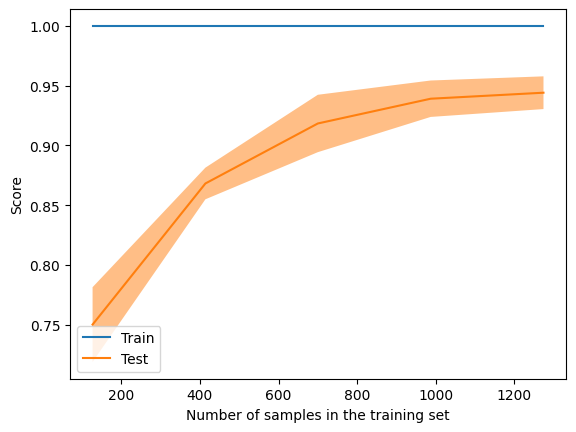

In [13]:
train_sizes, train_scores, test_scores = learning_curve(svc.best_estimator_, x_train, y_train)
display = LearningCurveDisplay(train_sizes=train_sizes, train_scores=train_scores, test_scores=test_scores, score_name="Score")
display.plot()
# plt.legend(["Accuratezza sul train set", "Accuratezza sul test set"])

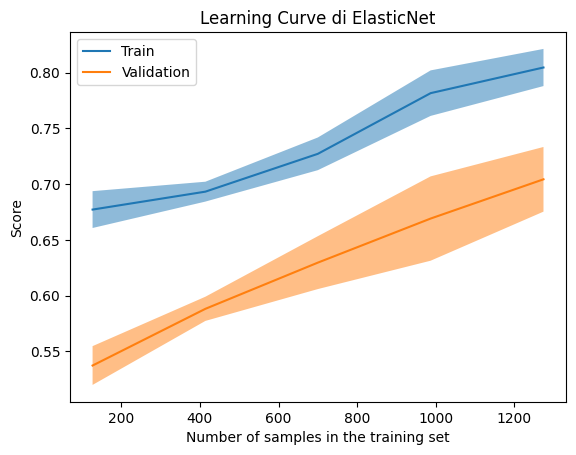

In [5]:
import warnings

warnings.filterwarnings("ignore")

train_sizes, train_scores, test_scores = learning_curve(elasticNet.best_estimator_, x_train, y_train)
display = LearningCurveDisplay(train_sizes=train_sizes, train_scores=train_scores, test_scores=test_scores, score_name="Score")
display.plot()
plt.title("Learning Curve di ElasticNet")
plt.legend(["Train", "Validation"])
plt.show()

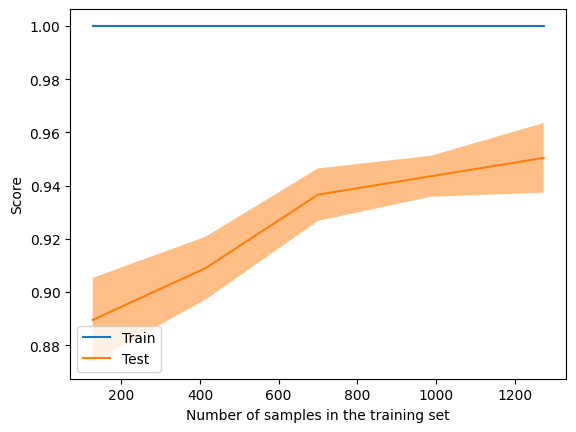

In [13]:
train_sizes, train_scores, test_scores = learning_curve(HistgradientBoosting.best_estimator_, x_train, y_train)
display = LearningCurveDisplay(train_sizes=train_sizes, train_scores=train_scores, test_scores=test_scores, score_name="Score")
display.plot()
plt.title("Learning Curve di Hist Gradient Boosting")
plt.show()

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(ensemble, x_train, y_train)
display = LearningCurveDisplay(train_sizes=train_sizes, train_scores=train_scores, test_scores=test_scores, score_name="Score")
display.plot()

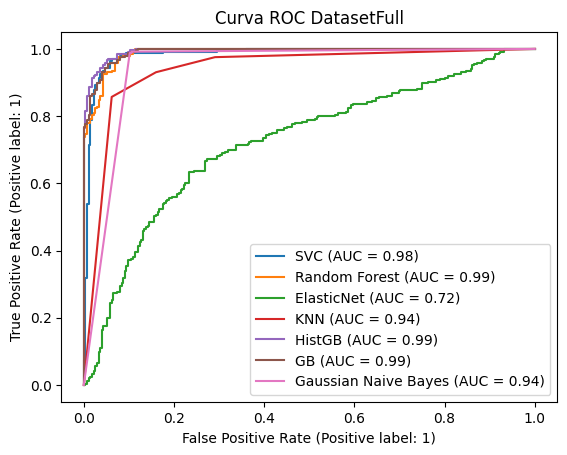

In [9]:
ax = plt.gca()
ax.set_title('Curva ROC DatasetFull')


svc_disp = RocCurveDisplay.from_estimator(svc, x_test, y_test, name="SVC", ax=ax)
rfc_disp = RocCurveDisplay.from_estimator(randomForest,  x_test, y_test, name="Random Forest", ax=ax)
elasticNet_disp = RocCurveDisplay.from_estimator(elasticNet,  x_test, y_test, name="ElasticNet", ax=ax)
knn_disp = RocCurveDisplay.from_estimator(knn,  x_test, y_test, name="KNN", ax=ax)
HistgradientBoosting_disp = RocCurveDisplay.from_estimator(HistgradientBoosting,  x_test, y_test, name="HistGB", ax=ax)
gradientBoosting_disp = RocCurveDisplay.from_estimator(GradientBoosting,  x_test, y_test, name="GB", ax=ax)
naiveBayes_disp = RocCurveDisplay.from_estimator(naiveBayes,  x_test, y_test, name="Gaussian Naive Bayes", ax=ax)

In [6]:
ensemble = joblib.load('../../Modelli/DatasetFull/ensemble.pkl')
ensembleSoft = joblib.load('../../Modelli/DatasetFull/ensembleSoft.pkl')
ensembleWeighted = joblib.load('../../Modelli/DatasetFull/ensembleWeighted.pkl')

In [ ]:
train_sizes = list(range(100, 1300, 100))
train_scores = []
test_scores = []

for i in train_sizes:
    print(i)
    ensembleSoft.fit(x_train[:i], y_train[:i])
    train_scores.append(ensembleSoft.score(x_train[:i], y_train[:i]))
    test_scores.append(ensembleSoft.score(x_test, y_test))

display = LearningCurveDisplay(train_sizes=train_sizes, train_scores=train_scores, test_scores=test_scores, score_name="Score")
display.plot()
plt.title("Learning Curve di Ensemble Soft")
plt.show()

In [7]:
train_sizes = list(range(100, 1300, 100))
train_sizes, train_scores, test_scores = learning_curve(estimator=ensembleSoft, X=x_train, y=y_train, train_sizes=train_sizes, n_jobs=-1)
display = LearningCurveDisplay(train_sizes=train_sizes, train_scores=train_scores, test_scores=test_scores, score_name="Score")
display.plot()
plt.title("Learning Curve di Ensemble Soft")
plt.legend(["Train", "Validation"])
plt.show()

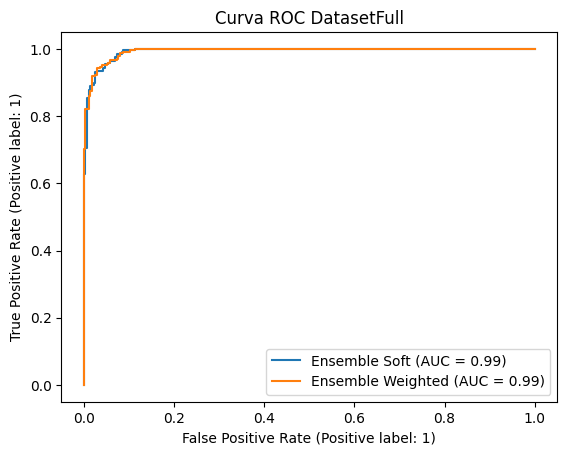

In [13]:
ax = plt.gca()
ax.set_title('Curva ROC DatasetFull')

ensembleSoft_disp = RocCurveDisplay.from_estimator(ensembleSoft, x_test, y_test, name="Ensemble Soft", ax=ax)
ensembleWeighted_disp = RocCurveDisplay.from_estimator(ensembleWeighted, x_test, y_test, name="Ensemble Weighted", ax=ax)

Occhio ricalcolare su ensemble soft perché è diverso

<h1> DatasetFull </h1>

| Modello                     | Iperparametri                                                                                                               | Training Accuracy | Test Accuracy | Precision | Recall | F1-score | Support |
|-----------------------------|-----------------------------------------------------------------------------------------------------------------------------|-------------------|---------------|-----------|--------|----------|---------|
| SVC                         | {'classifier__C': 128, 'classifier__gamma': 0.0078125, 'classifier__kernel': 'rbf'}                                      | 0.9448            | 0.95          | 0.95      | 0.95   | 0.95     | 520     |
| Random Forest               | {'classifier__max_depth': 9, 'classifier__n_estimators': 200}                                                             | 0.9347            | 0.9423        | 0.94      | 0.94   | 0.94     | 520     |
| Elastic Net                 | {'classifier__C': 0.5, 'classifier__l1_ratio': 1, 'classifier__penalty': 'elasticnet', 'classifier__solver': 'saga'} | 0.7062            | 0.6865        | 0.68      | 0.69   | 0.68     | 520     |
| KNN                         | {'classifier__n_neighbors': 3, 'classifier__weights': 'uniform'}                                                          | 0.8920            | 0.8827        | 0.88      | 0.88   | 0.88     | 520     |
| Hist Gradient Boosting      | {'classifier__learning_rate': 0.1, 'classifier__max_depth': 9, 'classifier__max_iter': 200}                               | 0.9491            | 0.9538        | 0.95      | 0.95   | 0.95     | 520     |
| Gradient Boosting           | Pipeline(steps=[('Scaling', MinMaxScaler()), ('classifier', GradientBoostingClassifier(max_depth=5, n_estimators=150))])  | 1.0               | 0.9442        | 0.94      | 0.95   | 0.94     | 520     |
| Naive Bayes                 | Pipeline(steps=[('Scaling', MinMaxScaler()), ('classifier', GaussianNB())])                                               | 0.9153            | 0.9404        | 0.94      | 0.94   | 0.94     | 520     |
| Ensemble model              | VotingClassifier(estimators=[('svc', SVC(C=128, gamma=0.0078125, probability=True)), ...                                  | 1.0               | 0.95          | 0.95      | 0.95   | 0.95     | 520     |
| Ensemble weighted model     | VotingClassifier(estimators=[('svc', SVC(C=128, gamma=0.0078125, probability=True)), ...                                  | 1.0               | 0.9462        | 0.95      | 0.95   | 0.95     | 520     |
| Manual ensemble model       | Models: svc, randomForest, knn, HistgradientBoosting, gradientBoosting, naiveBayes                                         | 1.0               | 0.95          | 0.95      | 0.95   | 0.95     | 520     |


<h1> DatasetZeroes </h1>

| Modello                     | Iperparametri                                                                                                                               | Training Accuracy | Test Accuracy | Precision | Recall | F1-score | Support |
|-----------------------------|---------------------------------------------------------------------------------------------------------------------------------------------|-------------------|---------------|-----------|--------|----------|---------|
| SVC                         | {'classifier__C': 8, 'classifier__gamma': 0.0078125, 'classifier__kernel': 'rbf', 'classifier__probability': True}                        | 0.9278            | 0.9462        | 0.95      | 0.95   | 0.95     | 520     |
| Random Forest               | {'classifier__max_depth': 12, 'classifier__n_estimators': 225}                                                                           | 0.9353            | 0.9365        | 0.94      | 0.94   | 0.94     | 520     |
| Elastic Net                 | {'classifier__C': 0.5, 'classifier__l1_ratio': 1, 'classifier__penalty': 'elasticnet', 'classifier__solver': 'saga'}                   | 0.6296            | 0.6404        | 0.67      | 0.63   | 0.61     | 520     |
| KNN                         | {'classifier__n_neighbors': 3, 'classifier__weights': 'uniform'}                                                                          | 0.6692            | 0.6769        | 0.73      | 0.69   | 0.67     | 520     |
| Hist Gradient Boosting      | {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__max_iter': 200}                                             | 0.9510            | 0.9558        | 0.96      | 0.96   | 0.96     | 520     |
| Gradient Boosting           | {'classifier__learning_rate': 0.1, 'classifier__loss': 'log_loss', 'classifier__max_depth': 5, 'classifier__n_estimators': 150}       | 0.9485            | 0.95          | 0.95      | 0.95   | 0.95     | 520     |
| Naive Bayes                 | Pipeline(steps=[('Scaling', MinMaxScaler()), ('classifier', GaussianNB())])                                                             | 0.9184            | 0.9404        | 0.94      | 0.94   | 0.94     | 520     |
| Ensemble model              | VotingClassifier(estimators=[('svc', SVC(C=8, gamma=0.0078125, probability=True)), ...                                                     | 0.9711            | 0.9462        | 0.95      | 0.95   | 0.95     | 520     |
| Ensemble weighted model     | VotingClassifier(estimators=[('svc', SVC(C=8, gamma=0.0078125, probability=True)), ...                                                     | 0.9912            | 0.9481        | 0.95      | 0.95   | 0.95     | 520     |
| Manual ensemble model       | Models: svc, randomForest, HistgradientBoosting, gradientBoosting, naiveBayes                                                            | 0.9887            | 0.9481        | 0.95      | 0.95   | 0.95     | 520     |


<h1> DatasetReduced </h1>

| Modello                     | Iperparametri                                                                                                                    | Training Accuracy | Test Accuracy | Precision | Recall | F1-score | Support |
|-----------------------------|----------------------------------------------------------------------------------------------------------------------------------|-------------------|---------------|-----------|--------|----------|---------|
| SVC                         | {'classifier__C': 128, 'classifier__gamma': 0.0078125, 'classifier__kernel': 'rbf', 'classifier__probability': True}          | 0.9784            | 0.9526        | 0.95      | 0.95   | 0.95     | 464     |
| Random Forest               | {'classifier__max_depth': 12, 'classifier__n_estimators': 225}                                                                  | 0.9724            | 0.9353        | 0.94      | 0.94   | 0.94     | 464     |
| Elastic Net                 | {'classifier__C': 0.5, 'classifier__l1_ratio': 1, 'classifier__penalty': 'elasticnet', 'classifier__solver': 'saga'}        | 0.7284            | 0.7672        | 0.76      | 0.73   | 0.74     | 464     |
| KNN                         | {'classifier__n_neighbors': 3, 'classifier__weights': 'uniform'}                                                                 | 0.7970            | 0.7522        | 0.76      | 0.70   | 0.71     | 464     |
| Hist Gradient Boosting      | {'classifier__learning_rate': 0.1, 'classifier__max_depth': 9, 'classifier__max_iter': 100}                                    | 0.9784            | 0.9504        | 0.94      | 0.95   | 0.95     | 464     |
| Gradient Boosting           | {'classifier__learning_rate': 0.1, 'classifier__loss': 'log_loss', 'classifier__max_depth': 3, 'classifier__n_estimators': 200} | 0.9754            | 0.9418        | 0.94      | 0.94   | 0.94     | 464     |
| Naive Bayes                 | Pipeline(steps=[('Scaling', MinMaxScaler()), ('classifier', GaussianNB())])                                                    | 0.9239            | 0.9052        | 0.93      | 0.88   | 0.89     | 464     |
| Ensemble model              | VotingClassifier(estimators=[('svc', SVC(C=128, gamma=0.0078125, probability=True)), ...                                          | 1.0               | 0.9461        | 0.95      | 0.94   | 0.94     | 464     |
| Ensemble weighted model     | VotingClassifier(estimators=[('svc', SVC(C=128, gamma=0.0078125, probability=True)), ...                                          | 1.0               | 0.9483        | 0.95      | 0.95   | 0.95     | 464     |
| Manual ensemble model       | Models: svc, randomForest, HistgradientBoosting, gradientBoosting, naiveBayes                                                   | 1.0               | 0.9461        | 0.94      | 0.94   | 0.94     | 464     |


<h1>Allenamento ensemble con feature selected</h1>

In [5]:
ensembleSoft = joblib.load('../../Modelli/DatasetFull/ensembleSoft.pkl')
rfe = joblib.load('../../ShapValues/DatasetFull/ensemble_featureSelected.pkl')

In [14]:
print("Ensemble model:")
print("Iperparametri: ", ensembleSoft.named_steps['classifier'])
print("Training accuracy: ", ensembleSoft.score(x_train, y_train))
print("Test accuracy: ", ensembleSoft.score(x_test, y_test))
print(classification_report(y_test, ensembleSoft.predict(x_test)))

Ensemble model:
Iperparametri:  VotingClassifier(estimators=[('svc',
                              SVC(C=128, gamma=0.0078125, probability=True)),
                             ('randomForest',
                              RandomForestClassifier(max_depth=9,
                                                     n_estimators=200)),
                             ('HistGradientBoosting',
                              HistGradientBoostingClassifier(max_depth=9,
                                                             max_iter=200)),
                             ('gradientBoosting',
                              GradientBoostingClassifier(max_depth=5,
                                                         n_estimators=150)),
                             ('naiveBayes', GaussianNB())],
                 n_jobs=50, voting='soft')
Training accuracy:  1.0
Test accuracy:  0.95
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       275
         

In [40]:
sortedFeature = dict(sorted(rfe.items(), key=lambda x: x[1], reverse=True))
feature = list(sortedFeature.keys())[0]

x_train = x_train.filter(items=feature)
x_test = x_test.filter(items=feature)

In [38]:
ensembleSoft.fit(x_train.filter(items=feature), y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('classifier',
                 VotingClassifier(estimators=[('svc',
                                               SVC(C=128, gamma=0.0078125,
                                                   probability=True)),
                                              ('randomForest',
                                               RandomForestClassifier(max_depth=9,
                                                                      n_estimators=200)),
                                              ('HistGradientBoosting',
                                               HistGradientBoostingClassifier(max_depth=9,
                                                                              max_iter=200)),
                                              ('gradientBoosting',
                                               GradientBoostingClassifier(max_depth=5,
                                                                          n_estimators=150)),
                                              ('naiveBayes', GaussianNB())],
                                  n_jobs=50, voting='soft'))])

In [42]:
ensembleSoft.score(x_train, y_train)
ensembleSoft.score(x_test, y_test)

0.948076923076923

In [43]:
joblib.dump(ensembleSoft, '../../Modelli/DatasetFull/ensembleSelected.pkl')

['../../Modelli/DatasetFull/ensembleSelected.pkl']

In [4]:
ensembleSelected = joblib.load('../../Modelli/DatasetFull/ensembleSelected.pkl')
x_train[ensemble.feature_names_in_]

,RPL23,HLA-DRB1,ALDOA,GIT2,SKI,ARHGAP4,ZNF223,DDX6,DPYSL2,ASAH1,...,TNFSF9,TTLL12,PTPN22,TMSB10,ZNF175,MMP25,ADAM15,RAD21,LANCL2,PSMC2
1226,10.464161,10.013445,10.345138,7.623669,7.718400,9.362555,5.952180,8.359181,10.151339,8.011108,...,5.726492,7.980547,8.419663,13.079268,6.610905,7.302158,7.921695,8.533568,7.342569,8.415954
1495,10.442206,12.783201,10.230253,7.661774,7.076381,9.365177,5.903887,8.339364,10.224588,8.350065,...,5.974831,7.963796,8.399697,13.077213,6.490909,7.236726,7.930723,8.856778,7.225465,8.413804
1696,10.422910,11.526725,10.287875,7.623838,7.399283,9.497305,6.146995,8.408620,10.005252,8.686985,...,5.708469,8.042217,8.289927,13.022936,6.584035,7.356124,7.990303,8.753769,7.174483,8.386502
478,10.449213,11.495784,10.304734,7.670272,7.360900,9.476552,6.019088,8.409845,10.181629,8.661393,...,5.911393,7.863537,8.582586,13.095700,6.519982,7.339821,7.754727,8.689809,7.289595,8.378294
2086,10.427290,11.476987,10.309569,7.620675,7.313841,9.352170,6.019690,8.396678,10.018959,8.706045,...,6.113562,8.041847,8.361220,13.087360,6.556876,7.198294,7.969528,8.678999,7.262688,8.432751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1506,10.424941,10.624655,10.360502,7.614835,7.422698,9.325697,5.941017,8.295895,10.116036,9.013204,...,6.028567,7.983961,8.445283,13.083514,6.503895,7.317400,7.907942,8.600845,7.052237,8.440795
1714,10.429645,11.569376,10.300410,7.633836,7.426066,9.586689,5.665670,8.413319,10.398153,8.679542,...,5.924051,8.024089,8.283856,13.046043,6.424141,7.472511,8.210942,8.729412,7.186158,8.377890
1148,10.611410,11.506032,10.523689,7.595572,7.129654,9.601858,5.896884,7.666433,10.037893,8.907005,...,5.972243,8.273116,8.177906,13.126649,6.522546,7.087983,8.033847,8.746240,7.287906,8.293211
1924,10.446339,11.399067,10.288441,7.623019,7.462579,9.460657,5.942570,8.414115,9.894637,8.616809,...,6.127004,8.036080,8.221118,13.067593,6.429411,7.448991,8.007609,8.646069,6.956068,8.364644
